In [ ]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
path = '/content/drive/MyDrive/Project  RUL'
evchargedata = os.path.join(path, 'evchargedata.csv')
evtripdata = os.path.join(path, 'evtripdata.csv')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Data Loading and Initial Preparation ---
charge_data = pd.read_csv(evchargedata)

# Convert date/time columns to datetime objects
charge_data['BatteryChargeStartDate'] = pd.to_datetime(charge_data['BatteryChargeStartDate'])
charge_data['BatteryChargeStopDate'] = pd.to_datetime(charge_data['BatteryChargeStopDate'])

# Sort data by ParticipantID and start date for proper RUL calculation
charge_data = charge_data.sort_values(by=['ParticipantID', 'BatteryChargeStartDate']).reset_index(drop=True)

# --- Feature Engineering and RUL Calculation ---
# Capacity Added Proxy
charge_data['CapacityAdded'] = charge_data['Ending SoC (of 12)'] - charge_data['Starting SoC (of 12)']

# Cycle Count
charge_data['CycleCount'] = charge_data.groupby('ParticipantID').cumcount() + 1
max_cycles = charge_data.groupby('ParticipantID')['CycleCount'].max()
charge_data['TotalCycles'] = charge_data['ParticipantID'].map(max_cycles)

# Remaining Useful Life (RUL)
charge_data['RUL'] = charge_data['TotalCycles'] - charge_data['CycleCount']

# --- Data Preparation for Random Forest ---

# Select features and target (RUL)
features = ['CycleCount', 'CapacityAdded']
X_data = charge_data[features].values
Y_data = charge_data['RUL'].values

# Scale features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_data)

print("--- Data After Feature Engineering and Scaling ---")
print(f"Total samples: {X_scaled.shape[0]}")
print(f"Features: {features}")
print(f"X (scaled features) sample head:\n{X_scaled[:5]}")
print(f"Y (RUL) sample head:\n{Y_data[:5]}")

# Split data into training and testing sets (80/20 split)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled,
    Y_data,
    test_size=0.2,
    random_state=42,

)

print(f"\n--- Train/Test Split Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")



--- Data After Feature Engineering and Scaling ---
Total samples: 76698
Features: ['CycleCount', 'CapacityAdded']
X (scaled features) sample head:
[[0.         0.76923077]
 [0.00099108 0.23076923]
 [0.00198216 0.15384615]
 [0.00297324 0.38461538]
 [0.00396432 0.23076923]]
Y (RUL) sample head:
[461 460 459 458 457]

--- Train/Test Split Shapes ---
X_train shape: (61358, 2)
Y_train shape: (61358,)
X_test shape: (15340, 2)
Y_test shape: (15340,)


In [ ]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=5)

# Train the model
print("\n--- Training Random Forest Regressor (This may take a moment) ---")
rf_model.fit(X_train, Y_train)
print("--- Training Complete ---")

# --- Prediction and Evaluation ---
Y_pred = rf_model.predict(X_test)

# Calculate Metrics
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("\n--- Model Performance Metrics (Random Forest) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} cycles")
print(f"R-squared (R2) Score: {r2:.4f}")


--- Training Random Forest Regressor (This may take a moment) ---
--- Training Complete ---

--- Model Performance Metrics (Random Forest) ---
Mean Absolute Error (MAE): 111.85 cycles
R-squared (R2) Score: 0.2186


In [ ]:
feature_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
feature_importances.to_csv('rf_feature_importances.csv', header=True)

# Save X_data and scaler for visualization
np.save('X_data_raw.npy', X_data)
np.save('X_data_scaled.npy', X_scaled)

# Save test results for visualization
np.save('Y_test.npy', Y_test)
np.save('Y_pred.npy', Y_pred)

--- Data After Feature Engineering and Scaling ---
Total samples: 76698
Features: ['CycleCount', 'CapacityAdded']
X (scaled features) sample head:
[[0.         0.76923077]
 [0.00099108 0.23076923]
 [0.00198216 0.15384615]
 [0.00297324 0.38461538]
 [0.00396432 0.23076923]]
Y (RUL) sample head:
[461 460 459 458 457]

--- Train/Test Split Shapes ---
X_train shape: (61358, 2)
Y_train shape: (61358,)
X_test shape: (15340, 2)
Y_test shape: (15340,)

--- Training Random Forest Regressor (This may take a moment) ---
--- Training Complete ---

--- Model Performance Metrics (Random Forest) ---
Mean Absolute Error (MAE): 112.32 cycles
R-squared (R2) Score: 0.2086


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# --- SETUP VARIABLES FOR VISUALIZATION ---
charge_data = pd.read_csv(evchargedata)
charge_data['CapacityAdded'] = charge_data['Ending SoC (of 12)'] - charge_data['Starting SoC (of 12)']
charge_data['CycleCount'] = charge_data.groupby('ParticipantID').cumcount() + 1
max_cycles = charge_data.groupby('ParticipantID')['CycleCount'].max()
charge_data['TotalCycles'] = charge_data['ParticipantID'].map(max_cycles)
charge_data['RUL'] = charge_data['TotalCycles'] - charge_data['CycleCount']

features = ['CycleCount', 'CapacityAdded']
X_data = charge_data[features].values
Y_data = charge_data['RUL'].values
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_data)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_data, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)


In [ ]:

charge_data.head()

,ParticipantID,BatteryChargeStartDate,BatteryChargeStopDate,Starting SoC (of 12),Ending SoC (of 12),CapacityAdded,CycleCount,TotalCycles,RUL
0,GC10,2014-02-16 16:05:00.000,2014-02-16 17:05:00.000,1,11,10,1,1009,1008
1,GC10,2014-02-16 18:20:00.000,2014-02-16 19:00:00.000,2,11,9,2,1009,1007
2,GC10,2014-02-17 08:10:00.000,2014-02-17 15:57:00.000,4,12,8,3,1009,1006
3,GC10,2014-02-18 07:41:00.000,2014-02-18 09:52:00.000,5,8,3,4,1009,1005
4,GC10,2014-02-18 15:36:00.000,2014-02-18 15:39:00.000,4,4,0,5,1009,1004


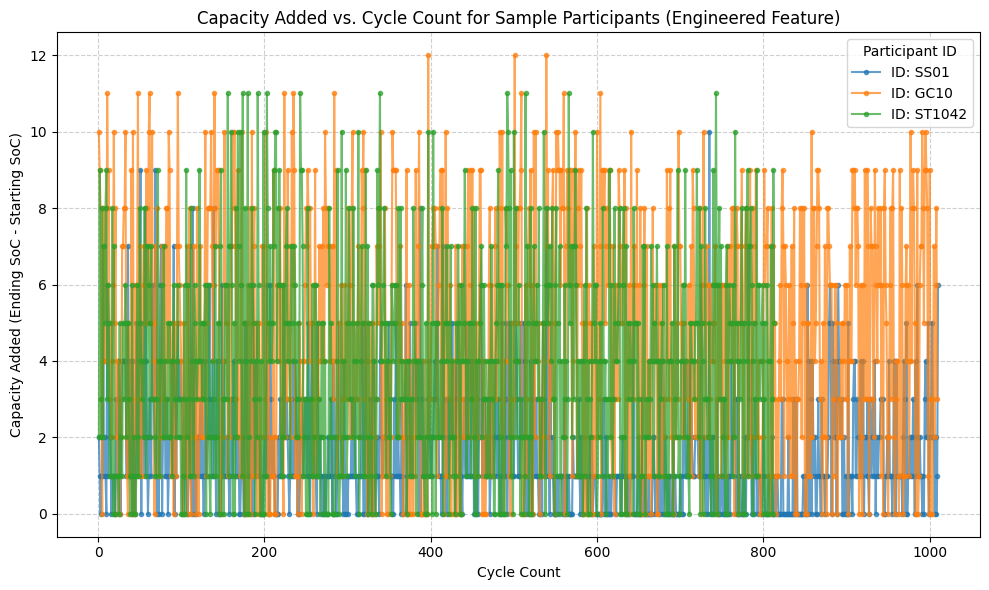

In [ ]:
selected_participants = charge_data['ParticipantID'].value_counts().nlargest(3).index.tolist()
plot_data = charge_data[charge_data['ParticipantID'].isin(selected_participants)]

plt.figure(figsize=(10, 6))
for participant in selected_participants:
    p_data = plot_data[plot_data['ParticipantID'] == participant]
    plt.plot(p_data['CycleCount'], p_data['CapacityAdded'], marker='o', markersize=3, linestyle='-', alpha=0.7, label=f'ID: {participant}')
plt.title('Capacity Added vs. Cycle Count for Sample Participants (Engineered Feature)')
plt.xlabel('Cycle Count')
plt.ylabel('Capacity Added (Ending SoC - Starting SoC)')
plt.legend(title='Participant ID')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

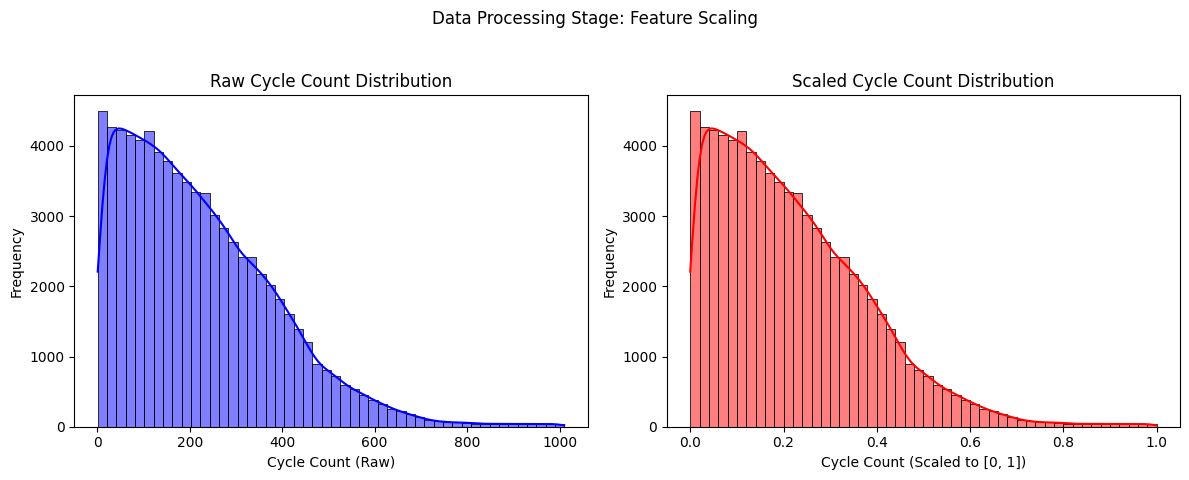

In [ ]:
cycle_count_raw = X_data[:, 0]
cycle_count_scaled = X_scaled[:, 0]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(cycle_count_raw, bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Raw Cycle Count Distribution')
axes[0].set_xlabel('Cycle Count (Raw)')
axes[0].set_ylabel('Frequency')
sns.histplot(cycle_count_scaled, bins=50, kde=True, ax=axes[1], color='red')
axes[1].set_title('Scaled Cycle Count Distribution')
axes[1].set_xlabel('Cycle Count (Scaled to [0, 1])')
axes[1].set_ylabel('Frequency')
plt.suptitle('Data Processing Stage: Feature Scaling')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


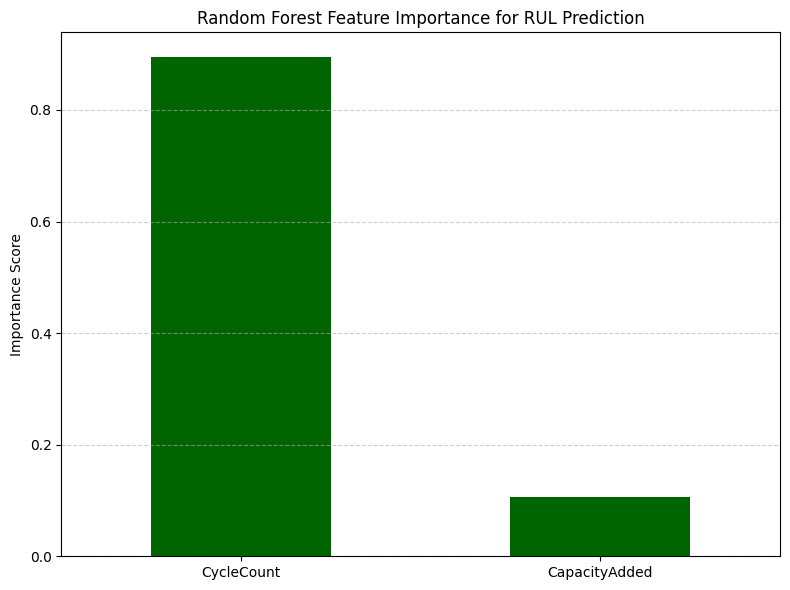

In [ ]:
feature_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
feature_importances.plot(kind='bar', color='darkgreen')
plt.title('Random Forest Feature Importance for RUL Prediction')
plt.ylabel('Importance Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

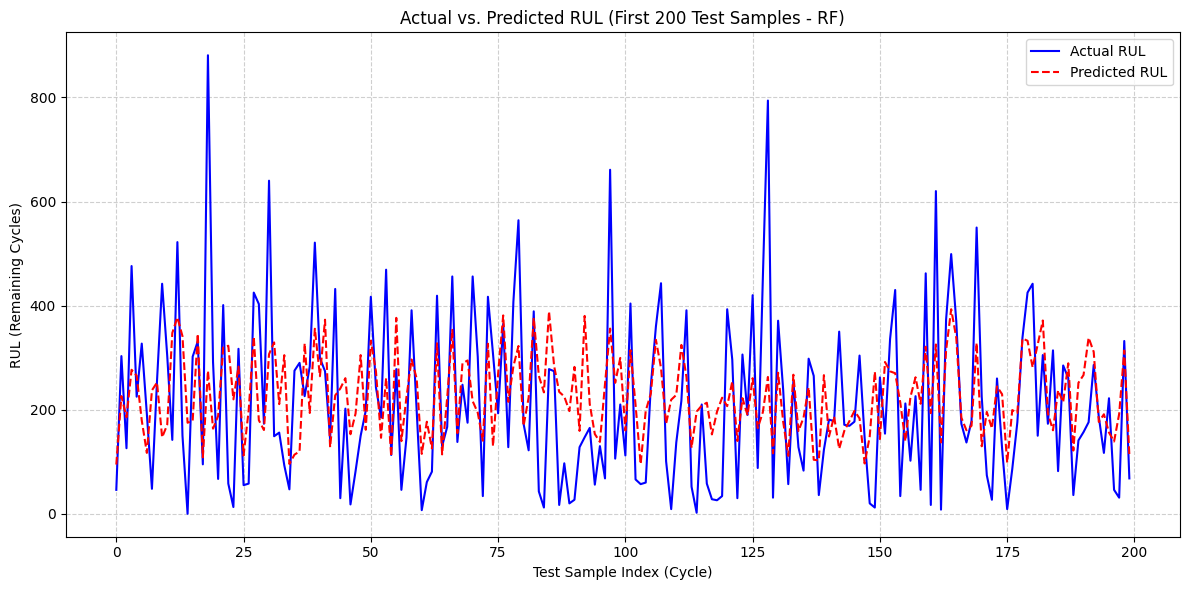

In [ ]:
segment_length = 200
plt.figure(figsize=(12, 6))
plt.plot(Y_test[:segment_length], label='Actual RUL', linestyle='-', color='blue')
plt.plot(Y_pred[:segment_length], label='Predicted RUL', linestyle='--', color='red')
plt.title(f'Actual vs. Predicted RUL (First {segment_length} Test Samples - RF)')
plt.xlabel('Test Sample Index (Cycle)')
plt.ylabel('RUL (Remaining Cycles)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
